# Preprocess
Author: Ida Thrane (idth@itu.dk)

This notebook preprocesses the data from its original values to an input ready for model optimization.

In [1]:
# Import libraries
import os
os.environ['USE_PYGEOS'] = '0'

import osmnx as ox
import pandas as pd
from shapely import wkt
import geopandas as gpd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import shuffle
from sklearn import preprocessing
import pickle
import geopy.distance

### Load tree data
Obtained from https://www.opendata.dk/city-of-copenhagen/trae-basis-kommunale-traeer.

In [3]:
#Define dataframe
df = pd.read_csv('trædata/trae_basis.csv')

#Create geometry object
df['wkb_geometry'] = df['wkb_geometry'].apply(wkt.loads)

#Create longitude and latitude columns
df['lon'] = df.wkb_geometry.apply(lambda p: p.x)
df['lat'] = df.wkb_geometry.apply(lambda p: p.y)

#Transform dataframe into Geodataframe in the 4326 crs projection
gdf = gpd.GeoDataFrame(df, geometry='wkb_geometry', crs=4326)
gdf.head()

/var/folders/92/g6x9yhvs6qs640vx7psry10r0000gn/T/ipykernel_32495/1701249275.py:1: DtypeWarning: Columns (51,56,57,58,59,60,75,79,81,83,86,89,93,99,113,127,145,146,147,157,166,167,168,184,185,186,187,188,189,190,191) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('trædata/trae_basis.csv')


FID kategori saerligt_trae    id  \
0  trae_basis.fid--3b437348_1860746ecc5_-3eef  gadetræ           nej  2667   
1  trae_basis.fid--3b437348_1860746ecc5_-3eed  gadetræ           nej  2669   
2  trae_basis.fid--3b437348_1860746ecc5_-3eec  gadetræ           nej  2676   
3  trae_basis.fid--3b437348_1860746ecc5_-3eeb  gadetræ           nej  2680   
4  trae_basis.fid--3b437348_1860746ecc5_-3ee9  gadetræ           nej  2681   

      type                              element              under_element  \
0  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   
1  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   
2  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   
3  2 Træer  2.1 Fuldkronede gade- og torvetræer            2.1.1 Gadetræer   
4  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   

        ny_dm_element ny_dm_under_element  arbsted_tekst_id  ... torso_stamme  \
0       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...          NaN   
1       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...          NaN   
2       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...          NaN   
3  Gade- og allétræer             Allétræ  Gadet_Gadet_3421  ...          NaN   
4       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...          NaN   

  torso_sidst_stynet torso_frekvens_styning torso_naeste_styning  \
0                NaN                    NaN                  NaN   
1                NaN                    NaN                  NaN   
2                NaN                    NaN                  NaN   
3                NaN                    NaN                  NaN   
4                NaN                    NaN                  NaN   

  torso_skaeres_ned_til torso_bemaerkning  ogc_fid               wkb_geometry  \
0                   NaN               NaN        1  POINT (12.53962 55.66533)   
1                   NaN               NaN        2  POINT (12.53965 55.66539)   
2                   NaN               NaN        3  POINT (12.53987 55.66581)   
3                   NaN               NaN        4  POINT (12.54003 55.66609)   
4                   NaN               NaN        5  POINT (12.54006 55.66615)   

         lon        lat  
0  12.539617  55.665327  
1  12.539651  55.665391  
2  12.539875  55.665805  
3  12.540025  55.666086  
4  12.540061  55.666150  

[5 rows x 196 columns]

In [79]:
#Find number of rows and columns of dataframe
gdf.shape

(63313, 196)

In [80]:
#First I check the distribution of trees, to see how many are related to streets, and how many will be sorted away
gdf["kategori"].value_counts()

kategori
parktræ           42141
gadetræ           20102
privat træ         1068
Ikke defineret        2
Name: count, dtype: int64

In [82]:
#Set a copy to retrieve all types of trees. Used for experiment 2.
gdf_street_features = gdf.copy()

In [81]:
#Set a copy to retrieve all types of trees. Used for experiment 3.
gdf_all = gdf.copy()

In [83]:
#Then I drop all rows except the ones that are marked as "gadetræ" in the "kategori"-column. I.e. street trees
gdf = gdf.query("kategori == 'gadetræ'")
gdf.head()

FID kategori saerligt_trae    id  \
0  trae_basis.fid--3b437348_1860746ecc5_-3eef  gadetræ           nej  2667   
1  trae_basis.fid--3b437348_1860746ecc5_-3eed  gadetræ           nej  2669   
2  trae_basis.fid--3b437348_1860746ecc5_-3eec  gadetræ           nej  2676   
3  trae_basis.fid--3b437348_1860746ecc5_-3eeb  gadetræ           nej  2680   
4  trae_basis.fid--3b437348_1860746ecc5_-3ee9  gadetræ           nej  2681   

      type                              element              under_element  \
0  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   
1  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   
2  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   
3  2 Træer  2.1 Fuldkronede gade- og torvetræer            2.1.1 Gadetræer   
4  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   

        ny_dm_element ny_dm_under_element  arbsted_tekst_id  ... torso_stamme  \
0       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...          NaN   
1       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...          NaN   
2       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...          NaN   
3  Gade- og allétræer             Allétræ  Gadet_Gadet_3421  ...          NaN   
4       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...          NaN   

  torso_sidst_stynet torso_frekvens_styning torso_naeste_styning  \
0                NaN                    NaN                  NaN   
1                NaN                    NaN                  NaN   
2                NaN                    NaN                  NaN   
3                NaN                    NaN                  NaN   
4                NaN                    NaN                  NaN   

  torso_skaeres_ned_til torso_bemaerkning  ogc_fid               wkb_geometry  \
0                   NaN               NaN        1  POINT (12.53962 55.66533)   
1                   NaN               NaN        2  POINT (12.53965 55.66539)   
2                   NaN               NaN        3  POINT (12.53987 55.66581)   
3                   NaN               NaN        4  POINT (12.54003 55.66609)   
4                   NaN               NaN        5  POINT (12.54006 55.66615)   

         lon        lat  
0  12.539617  55.665327  
1  12.539651  55.665391  
2  12.539875  55.665805  
3  12.540025  55.666086  
4  12.540061  55.666150  

[5 rows x 196 columns]

In [84]:
#Check the column "vejnavn", which contains streetnames, for nan-values. 
gdf["vejnavn"].isna().any()

True

In [85]:
print("Number of nan-values: ", len(gdf[gdf["vejnavn"].isna()]))
gdf["vejnavn"].value_counts()

Number of nan-values:  281


vejnavn
Vigerslev Allé       487
Vejlands Allé        397
Jagtvej              385
Artillerivej         302
Strandboulevarden    279
                    ... 
Bulgariensgade         1
Tingskiftevej          1
Høyensgade             1
Cypernsvej             1
Mellemtoftevej         1
Name: count, Length: 811, dtype: int64

From the above cell we see that the column "vejnavn" contains nan-values. Therefore OSMnx will be used to find the closest street for each tree to replace the nan-values.

### Find relation from each tree to its closest street using osmnx

In [86]:
#Load graph of Copenhagen Municipality to obtain all streets in the district
#G = ox.graph_from_place('Copenhagen Municipality, Denmark')

In [87]:
#Save graph for later use 
#ox.save_graphml(G, "graphs/cph_graph.graphml")

#Load graph
G = ox.load_graphml("graphs/cph_graph.graphml")

In [88]:
#Find the closest street from each point, which describes a tree
closest_streets = ox.distance.nearest_edges(G, gdf["lon"], gdf["lat"], return_dist=True)

In [89]:
#Define the edges which describe each closest street
closest_edges = closest_streets[0]
distances = closest_streets[1]

#Create columns in gdfs of street and distance from tree to street
gdf["street"]=closest_edges
gdf["distance_to_street"]=distances

gdf.head()

FID kategori saerligt_trae    id  \
0  trae_basis.fid--3b437348_1860746ecc5_-3eef  gadetræ           nej  2667   
1  trae_basis.fid--3b437348_1860746ecc5_-3eed  gadetræ           nej  2669   
2  trae_basis.fid--3b437348_1860746ecc5_-3eec  gadetræ           nej  2676   
3  trae_basis.fid--3b437348_1860746ecc5_-3eeb  gadetræ           nej  2680   
4  trae_basis.fid--3b437348_1860746ecc5_-3ee9  gadetræ           nej  2681   

      type                              element              under_element  \
0  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   
1  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   
2  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   
3  2 Træer  2.1 Fuldkronede gade- og torvetræer            2.1.1 Gadetræer   
4  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   

        ny_dm_element ny_dm_under_element  arbsted_tekst_id  ...  \
0       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...   
1       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...   
2       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...   
3  Gade- og allétræer             Allétræ  Gadet_Gadet_3421  ...   
4       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...   

  torso_frekvens_styning torso_naeste_styning torso_skaeres_ned_til  \
0                    NaN                  NaN                   NaN   
1                    NaN                  NaN                   NaN   
2                    NaN                  NaN                   NaN   
3                    NaN                  NaN                   NaN   
4                    NaN                  NaN                   NaN   

  torso_bemaerkning ogc_fid               wkb_geometry        lon        lat  \
0               NaN       1  POINT (12.53962 55.66533)  12.539617  55.665327   
1               NaN       2  POINT (12.53965 55.66539)  12.539651  55.665391   
2               NaN       3  POINT (12.53987 55.66581)  12.539875  55.665805   
3               NaN       4  POINT (12.54003 55.66609)  12.540025  55.666086   
4               NaN       5  POINT (12.54006 55.66615)  12.540061  55.666150   

                 street distance_to_street  
0  (8087161, 791980, 0)           0.000057  
1  (8087161, 791980, 0)           0.000058  
2  (8087161, 791980, 0)           0.000062  
3  (8087161, 791980, 0)           0.000064  
4  (8087161, 791980, 0)           0.000066  

[5 rows x 198 columns]

In [90]:
###The same is done for all tree types
closest_streets_all = ox.distance.nearest_edges(G, gdf_all["lon"], gdf_all["lat"], return_dist=True)
closest_edges_all = closest_streets_all[0]
distances_all = closest_streets_all[1]

gdf_all["street"]=closest_edges_all
gdf_all["distance_to_street"]=distances_all

gdf_all.head()

FID kategori saerligt_trae    id  \
0  trae_basis.fid--3b437348_1860746ecc5_-3eef  gadetræ           nej  2667   
1  trae_basis.fid--3b437348_1860746ecc5_-3eed  gadetræ           nej  2669   
2  trae_basis.fid--3b437348_1860746ecc5_-3eec  gadetræ           nej  2676   
3  trae_basis.fid--3b437348_1860746ecc5_-3eeb  gadetræ           nej  2680   
4  trae_basis.fid--3b437348_1860746ecc5_-3ee9  gadetræ           nej  2681   

      type                              element              under_element  \
0  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   
1  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   
2  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   
3  2 Træer  2.1 Fuldkronede gade- og torvetræer            2.1.1 Gadetræer   
4  2 Træer             2.2 Specialformede træer  2.2.2 Knudebeskårne træer   

        ny_dm_element ny_dm_under_element  arbsted_tekst_id  ...  \
0       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...   
1       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...   
2       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...   
3  Gade- og allétræer             Allétræ  Gadet_Gadet_3421  ...   
4       Formede træer   Knudebeskåret træ  Gadet_Gadet_3421  ...   

  torso_frekvens_styning torso_naeste_styning torso_skaeres_ned_til  \
0                    NaN                  NaN                   NaN   
1                    NaN                  NaN                   NaN   
2                    NaN                  NaN                   NaN   
3                    NaN                  NaN                   NaN   
4                    NaN                  NaN                   NaN   

  torso_bemaerkning ogc_fid               wkb_geometry        lon        lat  \
0               NaN       1  POINT (12.53962 55.66533)  12.539617  55.665327   
1               NaN       2  POINT (12.53965 55.66539)  12.539651  55.665391   
2               NaN       3  POINT (12.53987 55.66581)  12.539875  55.665805   
3               NaN       4  POINT (12.54003 55.66609)  12.540025  55.666086   
4               NaN       5  POINT (12.54006 55.66615)  12.540061  55.666150   

                 street distance_to_street  
0  (8087161, 791980, 0)           0.000057  
1  (8087161, 791980, 0)           0.000058  
2  (8087161, 791980, 0)           0.000062  
3  (8087161, 791980, 0)           0.000064  
4  (8087161, 791980, 0)           0.000066  

[5 rows x 198 columns]

In [91]:
#Check some cases, whether the street name is the same whether using column or osmnx method
print("OSMNX method street name: ", G.edges[(8087161, 791980,0)]['name'])
print("Column street name: ", gdf["vejnavn"][0])

print("OSMNX method street name: ", G.edges[(8087161, 791980,0)]['name'])
print("Column street name: ", gdf["vejnavn"][1])

print("OSMNX method street name: ", G.edges[(791980, 8087161, 0)]['name'])
print("Column street name: ", gdf["vejnavn"][2])

print("OSMNX method street name: ", G.edges[(791980, 8087161, 0)]['name'])
print("Column street name: ", gdf["vejnavn"][3])

print("OSMNX method street name: ", G.edges[(791980, 8087161, 0)]['name'])
print("Column street name: ", gdf["vejnavn"][4])

OSMNX method street name:  Ejderstedgade
Column street name:  Ejderstedgade
OSMNX method street name:  Ejderstedgade
Column street name:  Ejderstedgade
OSMNX method street name:  Ejderstedgade
Column street name:  Ejderstedgade
OSMNX method street name:  Ejderstedgade
Column street name:  Ejderstedgade
OSMNX method street name:  Ejderstedgade
Column street name:  Ejderstedgade


In [92]:
#Create node columns
gdf[['u', 'v','info']] = gpd.GeoDataFrame(gdf['street'].tolist(), index=gdf.index)

#Drop the information column
gdf = gdf.drop('info', axis = 1)

#Set all values in the tree column to 1 as this will be our positive class, and all rows in this dataframe describes a tree
gdf["tree"] = 1

#Create columns to keep count of number of trees located at each street
gdf['tree_count'] = gdf.groupby('street')['street'].transform('count')

#Drop duplicates on the node columns 
gdf = gdf.drop_duplicates(subset=['u', 'v'], keep='first')

#gdf = gdf.sort_values(by = ["planteaar"], ascending = False)

In [93]:
#Load and use spatial features which has a count of more than 0.

#building-counts
buildings = pd.read_csv("spatial_features/building_count.csv")
gdf = pd.merge(gdf, buildings, on=['u', 'v'], how = "left")

#landuse-counts
landuse = pd.read_csv("spatial_features/landuse_count.csv")
gdf = pd.merge(gdf, landuse, on=['u', 'v'], how = "left")

#natural-counts
natural = pd.read_csv("spatial_features/natural_count.csv")
gdf = pd.merge(gdf, natural, on=['u', 'v'], how = "left")

#places-counts
#places_p = pd.read_csv("spatial_features/places_p_count.csv")
#gdf = pd.merge(gdf, places_p, on=['u', 'v'], how = "left")

#railways-counts
railways_p = pd.read_csv("spatial_features/railways_p_count.csv")
gdf = pd.merge(gdf, railways_p, on=['u', 'v'], how = "left")

#roads-counts
roads_p = pd.read_csv("spatial_features/roads_p_count.csv")
gdf = pd.merge(gdf, roads_p, on=['u', 'v'], how = "left")

#Place of worship-counts
pofw = pd.read_csv("spatial_features/pofw_count.csv")
gdf = pd.merge(gdf, pofw, on=['u', 'v'], how = "left")

#Place of worship points-counts 
#pofw_p = pd.read_csv("spatial_features/pofw_p_count.csv")
#gdf = pd.merge(gdf, pofw_p, on=['u', 'v'], how = "left")

#Point of interest-counts
pois = pd.read_csv("spatial_features/pois_count.csv")
gdf = pd.merge(gdf, pois, on=['u', 'v'], how = "left")

#Point of interest points-counts
pois_p = pd.read_csv("spatial_features/pois_p_count.csv")
gdf = pd.merge(gdf, pois_p, on=['u', 'v'], how = "left")

#traffic-counts
traffic = pd.read_csv("spatial_features/traffic_count.csv")
gdf = pd.merge(gdf, traffic, on=['u', 'v'], how = "left")

#traffic points-counts
traffic_p = pd.read_csv("spatial_features/traffic_p_count.csv")
gdf = pd.merge(gdf, traffic_p, on=['u', 'v'], how = "left")

#transport-counts
transport_p = pd.read_csv("spatial_features/transport_p_count.csv")
gdf = pd.merge(gdf, transport_p, on=['u', 'v'], how = "left")

#water-counts
water = pd.read_csv("spatial_features/water_count.csv")
gdf = pd.merge(gdf, water, on=['u', 'v'], how = "left")

#waterways-counts
waterways_p = pd.read_csv("spatial_features/waterways_p_count.csv")
gdf = pd.merge(gdf, waterways_p, on=['u', 'v'], how = "left")

#Check that new columns have been added
gdf.head()

FID kategori saerligt_trae     id  \
0   trae_basis.fid--3b437348_186074710cb_-d6a  gadetræ           nej  99225   
1   trae_basis.fid--3b437348_186074710cb_-da9  gadetræ           nej  96459   
2   trae_basis.fid--3b437348_1860746ecc5_3b5d  gadetræ           nej  96492   
3   trae_basis.fid--3b437348_1860746ecc5_35af  gadetræ           nej  96720   
4  trae_basis.fid--3b437348_1860746ecc5_-3434  gadetræ           nej  97055   

      type                              element    under_element  \
0  2 Træer  2.1 Fuldkronede gade- og torvetræer              NaN   
1  2 Træer  2.1 Fuldkronede gade- og torvetræer              NaN   
2  2 Træer  2.1 Fuldkronede gade- og torvetræer              NaN   
3  2 Træer  2.1 Fuldkronede gade- og torvetræer  2.1.1 Gadetræer   
4  2 Træer  2.1 Fuldkronede gade- og torvetræer              NaN   

        ny_dm_element ny_dm_under_element  arbsted_tekst_id  ...  \
0  Gade- og allétræer             Gadetræ  Gadet_Gadet_3421  ...   
1  Gade- og allétræer             Gadetræ  Gadet_Gadet_3387  ...   
2  Gade- og allétræer             Gadetræ  Gadet_Gadet_2455  ...   
3  Gade- og allétræer             Gadetræ  Gadet_Gadet_2458  ...   
4  Gade- og allétræer             Gadetræ  Gadet_Gadet_2456  ...   

  railways_p_count roads_p_count pofw_count pois_count pois_p_count  \
0              NaN           3.0        NaN        NaN          NaN   
1              NaN           3.0        NaN        NaN          NaN   
2              NaN           9.0        NaN        NaN          NaN   
3              NaN           3.0        NaN        NaN          NaN   
4              NaN           3.0        NaN        NaN          NaN   

  traffic_count  traffic_p_count transport_p_count  water_count  \
0           NaN              NaN               NaN          NaN   
1           NaN              NaN               NaN          NaN   
2           NaN              NaN               NaN          NaN   
3           NaN              NaN               NaN          NaN   
4           NaN              NaN               NaN          NaN   

  waterways_p_count  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  

[5 rows x 215 columns]

In [95]:
#This is repeated for all trees
gdf_all[['u', 'v','info']] = gpd.GeoDataFrame(gdf_all['street'].tolist(), index=gdf_all.index)
gdf_all = gdf_all.drop('info', axis = 1)
gdf_all["tree"] = 1
gdf_all['tree_count'] = gdf_all.groupby('street')['street'].transform('count')
gdf_all = gdf_all.drop_duplicates(subset=['u', 'v'], keep='first')

#gdf_all = gdf_all.sort_values(by = ["planteaar"], ascending = False)

In [96]:
#This is repeated for all tree types

#building-counts
buildings = pd.read_csv("spatial_features/building_count.csv")
gdf_all = pd.merge(gdf_all, buildings, on=['u', 'v'], how = "left")

#landuse-counts
landuse = pd.read_csv("spatial_features/landuse_count.csv")
gdf_all = pd.merge(gdf_all, landuse, on=['u', 'v'], how = "left")

#natural-counts
natural = pd.read_csv("spatial_features/natural_count.csv")
gdf_all = pd.merge(gdf_all, natural, on=['u', 'v'], how = "left")

#places-counts
#places_p = pd.read_csv("spatial_features/places_p_count.csv")
#gdf = pd.merge(gdf, places_p, on=['u', 'v'], how = "left")

#railways-counts
railways_p = pd.read_csv("spatial_features/railways_p_count.csv")
gdf_all = pd.merge(gdf_all, railways_p, on=['u', 'v'], how = "left")

#roads-counts
roads_p = pd.read_csv("spatial_features/roads_p_count.csv")
gdf_all = pd.merge(gdf_all, roads_p, on=['u', 'v'], how = "left")

#Place of worship-counts
pofw = pd.read_csv("spatial_features/pofw_count.csv")
gdf_all = pd.merge(gdf_all, pofw, on=['u', 'v'], how = "left")

#Place of worship points-counts 
#pofw_p = pd.read_csv("spatial_features/pofw_p_count.csv")
#gdf = pd.merge(gdf, pofw_p, on=['u', 'v'], how = "left")

#Point of interest-counts
pois = pd.read_csv("spatial_features/pois_count.csv")
gdf_all = pd.merge(gdf_all, pois, on=['u', 'v'], how = "left")

#Point of interest points-counts
pois_p = pd.read_csv("spatial_features/pois_p_count.csv")
gdf_all = pd.merge(gdf_all, pois_p, on=['u', 'v'], how = "left")

#traffic-counts
traffic = pd.read_csv("spatial_features/traffic_count.csv")
gdf_all = pd.merge(gdf_all, traffic, on=['u', 'v'], how = "left")

#traffic points-counts
traffic_p = pd.read_csv("spatial_features/traffic_p_count.csv")
gdf_all = pd.merge(gdf_all, traffic_p, on=['u', 'v'], how = "left")

#transport-counts
transport_p = pd.read_csv("spatial_features/transport_p_count.csv")
gdf_all = pd.merge(gdf_all, transport_p, on=['u', 'v'], how = "left")

#water-counts
water = pd.read_csv("spatial_features/water_count.csv")
gdf_all = pd.merge(gdf_all, water, on=['u', 'v'], how = "left")

#waterways-counts
waterways_p = pd.read_csv("spatial_features/waterways_p_count.csv")
gdf_all = pd.merge(gdf_all, waterways_p, on=['u', 'v'], how = "left")

#Check that new columns have been added
gdf_all.head()

FID kategori saerligt_trae     id  \
0   trae_basis.fid--3b437348_186074710cb_-d6a  gadetræ           nej  99225   
1  trae_basis.fid--3b437348_186074710cb_-10e3  parktræ           nej  45123   
2  trae_basis.fid--3b437348_186074710cb_-10ef  parktræ           nej  99264   
3   trae_basis.fid--3b437348_186074710cb_-cc6  parktræ           nej  99310   
4  trae_basis.fid--3b437348_186074710cb_-10f4  parktræ           nej  99263   

      type                              element under_element  \
0  2 Træer  2.1 Fuldkronede gade- og torvetræer           NaN   
1  2 Træer                        2.3 Parktræer           NaN   
2  2 Træer                        2.3 Parktræer           NaN   
3  2 Træer                  Park- og naturtræer       Parktræ   
4  2 Træer                        2.3 Parktræer           NaN   

         ny_dm_element ny_dm_under_element  arbsted_tekst_id  ...  \
0   Gade- og allétræer             Gadetræ  Gadet_Gadet_3421  ...   
1  Park- og naturtræer             Parktræ   Viger_Viger_120  ...   
2  Park- og naturtræer             Parktræ   Valby_Valby_479  ...   
3  Park- og naturtræer             Parktræ  Viger_Viger_2250  ...   
4  Park- og naturtræer             Parktræ   Valby_Valby_479  ...   

  railways_p_count roads_p_count pofw_count pois_count pois_p_count  \
0              NaN           3.0        NaN        NaN          NaN   
1              NaN           6.0        NaN        1.0          NaN   
2              NaN           3.0        NaN        1.0          NaN   
3              1.0           4.0        NaN        NaN          NaN   
4              NaN           3.0        NaN        1.0          NaN   

  traffic_count  traffic_p_count transport_p_count  water_count  \
0           NaN              NaN               NaN          NaN   
1           NaN              NaN               NaN          NaN   
2           NaN              NaN               NaN          NaN   
3           NaN              NaN               NaN          NaN   
4           NaN              NaN               NaN          NaN   

  waterways_p_count  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  

[5 rows x 215 columns]

In [97]:
#Function to inspect the values contained in the tree dataset
def inspect(train_df_column):
    print("Number of null values:\n", train_df_column.isna().sum())
    print("Value counts of column:\n",train_df_column.value_counts())

In [98]:
#Make list of features directly related to trees
tree_features = ["slaegt", "bydelsnavn", "placering", "omgivelse", "planteaar", "tree_count"]

In [99]:
for i in tree_features:
    print(i,"\n", inspect(gdf[i]))

Number of null values:
 0
Value counts of column:
 slaegt
Tilia sp.             1663
Platanus sp.           870
Robinia sp.            525
Sorbus sp.             483
Quercus sp.            475
Fraxinus sp.           446
Acer sp.               411
Prunus sp.             302
Aesculus sp.           177
Crataegus sp.          162
Ulmus sp.              126
Malus sp.              116
Carpinus sp.            93
Alnus sp.               86
Betula sp.              79
Populus sp.             73
Pyrus sp.               72
Gleditsia sp.           65
Corylus sp.             35
Salix sp.               33
Liriodéndron sp.        29
Pinus sp.               27
Metasequoia sp.         25
Ailanthus sp.           24
Ikke registreret        22
Ginkgo sp.              22
Amelanchier sp.         15
Liquidambar sp.         15
Paulownia sp.           12
Larix sp.                4
Styphnolobium sp.        4
Cercidiphýllum sp.       3
Cornus sp.               3
Castanea sp.             3
Eleagnus sp.            

In [101]:
#Transform features from tree data such that they do not have nan-values

###Slægt 
#Value counts of the origin of a tree that are below 100 and the null-values will be grouped into 'other' category.
gdf.loc[gdf['slaegt'].isin((gdf['slaegt'].value_counts()[gdf['slaegt'].value_counts() < 100]).index), 'slaegt'] = 'other'
gdf["slaegt"] = gdf["slaegt"].fillna('other')

###Bydelsnavn
#Null values inserted into 'unknown'-category
gdf["bydelsnavn"] = gdf["bydelsnavn"].fillna('unknown')

###Placering
#Null values inserted into 'Ikke registreret'-category (i.e. not registrated)
gdf["placering"] = gdf["placering"].fillna('Ikke registreret')

###Omgivelse
#Null values inserted into 'Ikke registreret'-category (i.e. not registrated)
gdf["omgivelse"] = gdf["omgivelse"].fillna('Ikke registreret')

###Planteaar
#The nan-values will be replaced by the rounding of the mean-value of the column to keep the ordinal nature of this 
#categorical column
gdf["planteaar"] = gdf["planteaar"].fillna(round(gdf["planteaar"].mean()))

###Building_count
#The nan-values will be replaced by the rounding of the mean-value of the column to keep the ordinal nature of this 
#categorical column
gdf["buildings_count"] = gdf["buildings_count"].fillna(round(gdf["buildings_count"].mean()))

###Landuse_count
#The nan-values will be replaced by the rounding of the mean-value of the column to keep the ordinal nature of this 
#categorical column
gdf["landuse_count"] = gdf["landuse_count"].fillna(round(gdf["landuse_count"].mean()))

###Natural_count
#The nan-values will be replaced by 0.
gdf["natural_count"] = gdf["natural_count"].fillna(0)

###Places_count
#The nan-values will be replaced by 0.
#gdf["places_p_count"] = gdf["places_p_count"].fillna(0)

###railways_count
#The nan-values will be replaced by 0.
gdf["railways_p_count"] = gdf["railways_p_count"].fillna(0)

###Roads_count
#The nan-values will be replaced by 0.
gdf["roads_p_count"] = gdf["roads_p_count"].fillna(0)

###POFW
#The nan-values will be replaced by 0.
gdf["pofw_count"] = gdf["pofw_count"].fillna(0)

###POFW points
#The nan-values will be replaced by 0.
#gdf["pofw_p_count"] = gdf["pofw_p_count"].fillna(0)

###POIS
#The nan-values will be replaced by the rounding of the mean-value of the column to keep the ordinal nature of this 
#categorical column
gdf["pois_count"] = gdf["pois_count"].fillna(round(gdf["pois_count"].mean()))

###POIS points
#The nan-values will be replaced by 0.
gdf["pois_p_count"] = gdf["pois_p_count"].fillna(0)

###Traffic
#The nan-values will be replaced by 0.
gdf["traffic_count"] = gdf["traffic_count"].fillna(0)

###Traffic points
#The nan-values will be replaced by 0.
gdf["traffic_p_count"] = gdf["traffic_p_count"].fillna(0)

###Transport points
#The nan-values will be replaced by 0.
gdf["transport_p_count"] = gdf["transport_p_count"].fillna(0)

###Water
#The nan-values will be replaced by 0.
gdf["water_count"] = gdf["water_count"].fillna(0)

###Waterways
#The nan-values will be replaced by 0.
gdf["waterways_p_count"] = gdf["waterways_p_count"].fillna(0)


In [102]:
#gdf = gdf.to_csv("graphs/gdf.csv")
#gdf = pd.read_csv("graphs/gdf.csv")

#Create geometry object
#gdf['wkb_geometry'] = gdf['wkb_geometry'].apply(wkt.loads)
#gdf = gpd.GeoDataFrame(gdf, crs="EPSG:32632", geometry="wkb_geometry")


In [103]:
#This is repeated for all tree types

###Slægt 
#Value counts of the origin of a tree that are below 100 and the null-values will be grouped into 'other' category.
gdf_all.loc[gdf_all['slaegt'].isin((gdf_all['slaegt'].value_counts()[gdf_all['slaegt'].value_counts() < 100]).index), 'slaegt'] = 'other'
gdf_all["slaegt"] = gdf_all["slaegt"].fillna('other')

###Bydelsnavn
#Null values inserted into 'unknown'-category
gdf_all["bydelsnavn"] = gdf_all["bydelsnavn"].fillna('unknown')

###Placering
#Null values inserted into 'Ikke registreret'-category (i.e. not registrated)
gdf_all["placering"] = gdf_all["placering"].fillna('Ikke registreret')

###Omgivelse
#Null values inserted into 'Ikke registreret'-category (i.e. not registrated)
gdf_all["omgivelse"] = gdf_all["omgivelse"].fillna('Ikke registreret')

###Planteaar
#The nan-values will be replaced by the rounding of the mean-value of the column to keep the ordinal nature of this 
#categorical column
gdf_all["planteaar"] = gdf_all["planteaar"].fillna(round(gdf_all["planteaar"].mean()))

###Building_count
#The nan-values will be replaced by the rounding of the mean-value of the column to keep the ordinal nature of this 
#categorical column
gdf_all["buildings_count"] = gdf_all["buildings_count"].fillna(round(gdf_all["buildings_count"].mean()))

###Landuse_count
#The nan-values will be replaced by the rounding of the mean-value of the column to keep the ordinal nature of this 
#categorical column
gdf_all["landuse_count"] = gdf_all["landuse_count"].fillna(round(gdf_all["landuse_count"].mean()))

###Natural_count
#The nan-values will be replaced by 0.
gdf_all["natural_count"] = gdf_all["natural_count"].fillna(0)

###Places_count
#The nan-values will be replaced by 0.
#gdf["places_p_count"] = gdf["places_p_count"].fillna(0)

###railways_count
#The nan-values will be replaced by 0.
gdf_all["railways_p_count"] = gdf_all["railways_p_count"].fillna(0)

###Roads_count
#The nan-values will be replaced by 0.
gdf_all["roads_p_count"] = gdf_all["roads_p_count"].fillna(0)

###POFW
#The nan-values will be replaced by 0.
gdf_all["pofw_count"] = gdf_all["pofw_count"].fillna(0)

###POFW points
#The nan-values will be replaced by 0.
#gdf["pofw_p_count"] = gdf["pofw_p_count"].fillna(0)

###POIS
#The nan-values will be replaced by the rounding of the mean-value of the column to keep the ordinal nature of this 
#categorical column
gdf_all["pois_count"] = gdf_all["pois_count"].fillna(round(gdf_all["pois_count"].mean()))

###POIS points
#The nan-values will be replaced by 0.
gdf_all["pois_p_count"] = gdf_all["pois_p_count"].fillna(0)

###Traffic
#The nan-values will be replaced by 0.
gdf_all["traffic_count"] = gdf_all["traffic_count"].fillna(0)

###Traffic points
#The nan-values will be replaced by 0.
gdf_all["traffic_p_count"] = gdf_all["traffic_p_count"].fillna(0)

###Transport points
#The nan-values will be replaced by 0.
gdf_all["transport_p_count"] = gdf_all["transport_p_count"].fillna(0)

###Water
#The nan-values will be replaced by 0.
gdf_all["water_count"] = gdf_all["water_count"].fillna(0)

###Waterways
#The nan-values will be replaced by 0.
gdf_all["waterways_p_count"] = gdf_all["waterways_p_count"].fillna(0)


### Obtain street data from OSMnx
- To obtain information known about the streets for further use, while retaining information about the streets

In [104]:
#Load edges-dataset from Copenhagen Municipality using osmnx
#_, gdf_edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)

#Reset their indices
#gdf_edges = gdf_edges.reset_index(level=[0,1])

#Save gdf
#gdf_edges = gdf_edges.to_csv("graphs/gdf_edges.csv")

#Load gdf
gdf_edges = pd.read_csv("graphs/gdf_edges.csv")

#Create geometry object
gdf_edges['geometry'] = gdf_edges['geometry'].apply(wkt.loads)
gdf_edges = gpd.GeoDataFrame(gdf_edges, crs="EPSG:32632", geometry="geometry")

#Select columns for further analysis
gdf_edges = gdf_edges[['u', 'v', 'osmid', 'name', 'highway', 'maxspeed', 'length', 'lanes', 'geometry', 'bridge', 'tunnel']]

In [105]:
#Drop edge duplicates as they describe the same streets 
gdf_edges = gdf_edges.drop_duplicates(subset=['u', 'v'], keep='first')

In [106]:
#Merge with spatial features

gdf_edges = pd.merge(gdf_edges, buildings, on=['u', 'v'], how = "left")

gdf_edges = pd.merge(gdf_edges, landuse, on=['u', 'v'], how = "left")

gdf_edges = pd.merge(gdf_edges, natural, on=['u', 'v'], how = "left")

#gdf_edges = pd.merge(gdf_edges, places_p, on=['u', 'v'], how = "left")

gdf_edges = pd.merge(gdf_edges, railways_p, on=['u', 'v'], how = "left")

gdf_edges = pd.merge(gdf_edges, roads_p, on=['u', 'v'], how = "left")

gdf_edges = pd.merge(gdf_edges, pofw, on=['u', 'v'], how = "left")

#gdf_edges = pd.merge(gdf_edges, pofw_p, on=['u', 'v'], how = "left")

gdf_edges = pd.merge(gdf_edges, pois, on=['u', 'v'], how = "left")

gdf_edges = pd.merge(gdf_edges, pois_p, on=['u', 'v'], how = "left")

gdf_edges = pd.merge(gdf_edges, traffic, on=['u', 'v'], how = "left")

gdf_edges = pd.merge(gdf_edges, traffic_p, on=['u', 'v'], how = "left")

gdf_edges = pd.merge(gdf_edges, transport_p, on=['u', 'v'], how = "left")

gdf_edges = pd.merge(gdf_edges, water, on=['u', 'v'], how = "left")

gdf_edges = pd.merge(gdf_edges, waterways_p, on=['u', 'v'], how = "left")

gdf_edges.head()

u           v      osmid              name       highway maxspeed  \
0  118725  2512504197   27226011  Banegårdspladsen      tertiary       30   
1  118725  6357644306  140412993     Vesterbrogade      tertiary       50   
2  118730      118751    2371125         Vasbygade       primary       50   
3  118732  6534097568   25996200        Dybbølsbro      tertiary       40   
4  118732   283603631  683463579               NaN  primary_link       50   

   length lanes                                           geometry bridge  \
0  15.342   NaN          LINESTRING (12.563 55.674, 12.563 55.674)    NaN   
1  40.497     2  LINESTRING (12.563 55.674, 12.563 55.674, 12.5...    NaN   
2  77.486     2  LINESTRING (12.558 55.662, 12.558 55.662, 12.5...    NaN   
3   3.763     2          LINESTRING (12.562 55.663, 12.562 55.663)    NaN   
4   8.591     2          LINESTRING (12.562 55.663, 12.562 55.663)    NaN   

   ... railways_p_count  roads_p_count  pofw_count  pois_count  pois_p_count  \
0  ...              NaN            3.0         NaN         NaN           NaN   
1  ...              4.0            4.0         NaN         NaN           NaN   
2  ...              NaN            7.0         NaN         NaN           NaN   
3  ...              NaN            6.0         NaN         NaN           NaN   
4  ...              NaN            6.0         NaN         NaN           NaN   

   traffic_count  traffic_p_count  transport_p_count  water_count  \
0            NaN              1.0                NaN          NaN   
1            NaN              NaN                NaN          NaN   
2            NaN              1.0                NaN          NaN   
3            NaN              1.0                NaN          NaN   
4            NaN              2.0                NaN          NaN   

   waterways_p_count  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 24 columns]

In [107]:
#Make list of features directly related to streets
street_features = ["highway", "maxspeed", "length", "lanes", "bridge", "tunnel"]

In [108]:
#Inspect street features
for i in street_features:
    print(i,"\n", inspect(gdf_edges[i]))

Number of null values:
 0
Value counts of column:
 highway
footway                                                 34122
residential                                             22082
service                                                 19449
tertiary                                                 8549
path                                                     6794
                                                        ...  
['residential', 'tertiary_link']                            1
['motorway_link', 'trunk']                                  1
['trunk_link', 'tertiary', 'tertiary_link', 'trunk']        1
rest_area                                                   1
['footway', 'residential', 'cycleway']                      1
Name: count, Length: 95, dtype: int64
highway 
 None
Number of null values:
 75409
Value counts of column:
 maxspeed
50                    21855
40                     4087
30                      878
60                      506
15                      462
10

After inspecting each tree feature, it is decided how to transform each of them into a numerical format to be fit into a machine learning model.

In [109]:
#Transform street features to avoid nan-values
###Highway
#Group value counts below 3000 and null-values into "other"-category
gdf_edges.loc[gdf_edges['highway'].isin((gdf_edges['highway'].value_counts()[gdf_edges['highway'].value_counts() < 3000]).index), 'highway'] = 'other'
gdf_edges["highway"] = gdf_edges["highway"].fillna('other')

###Maxspeed
# Maxspeeds counted less than 100 times as well as the null-values will be grouped into the 50-category.
# The speed limit inside of city-borders in Denmark is by law 50 km/h as the default, why this is the chosen value
gdf_edges.loc[gdf_edges['maxspeed'].isin((gdf_edges['maxspeed'].value_counts()[gdf_edges['maxspeed'].value_counts() < 100]).index), 'maxspeed'] = 50.
gdf_edges["maxspeed"] = gdf_edges["maxspeed"].fillna(50.)
#The column is converted to numeric from string
gdf_edges["maxspeed"] = pd.to_numeric(gdf_edges["maxspeed"])

###Length
#Because 'length' is a numerical feature, the nan-values will be imputed by the mean-value of the column
gdf_edges["length"] = gdf_edges["length"].fillna(gdf_edges["length"].mean())

###Lanes
#Value counts of lanes that are below 500 and the null-values will be grouped into the 2-lanes category, which is the 
#most seen category in the dataset
gdf_edges.loc[gdf_edges['lanes'].isin((gdf_edges['lanes'].value_counts()[gdf_edges['lanes'].value_counts() < 500]).index), 'lanes'] = 2
gdf_edges["lanes"] = gdf_edges["lanes"].fillna(2)
#The column is converted to numeric from string
gdf_edges["lanes"] = pd.to_numeric(gdf_edges["lanes"])

###Bridge
#All rows which include a value will be grouped as 1 and all nan-values will be grouped as 0 to mark whether a street
#is attached to a bridge or not. 
gdf_edges.loc[gdf_edges['bridge'].isin((gdf_edges['bridge'].value_counts()[gdf_edges['bridge'].value_counts() > 0]).index), 'bridge'] = 1
gdf_edges["bridge"] = gdf_edges["bridge"].fillna(0)

###Tunnel
#Tunnels will be handled the same way as bridges
gdf_edges.loc[gdf_edges['tunnel'].isin((gdf_edges['tunnel'].value_counts()[gdf_edges['tunnel'].value_counts() > 0]).index), 'tunnel'] = 1
gdf_edges["tunnel"] = gdf_edges["tunnel"].fillna(0)

###Building_count
#The nan-values will be replaced by the rounding of the mean-value of the column to keep the ordinal nature of this 
#categorical column
gdf_edges["buildings_count"] = gdf_edges["buildings_count"].fillna(round(gdf_edges["buildings_count"].mean()))

###Landuse_count
#The nan-values will be replaced by the rounding of the mean-value of the column to keep the ordinal nature of this 
#categorical column
gdf_edges["landuse_count"] = gdf_edges["landuse_count"].fillna(round(gdf_edges["landuse_count"].mean()))

###Natural_count
#The nan-values will be replaced by 0.
gdf_edges["natural_count"] = gdf_edges["natural_count"].fillna(0)

###Places_p_count
#The nan-values will be replaced by 0.
#gdf_edges["places_p_count"] = gdf_edges["places_p_count"].fillna(0)

###Railways_p_count
#The nan-values will be replaced by 0.
gdf_edges["railways_p_count"] = gdf_edges["railways_p_count"].fillna(0)

###Roads_p_count
#The nan-values will be replaced by 0.
gdf_edges["roads_p_count"] = gdf_edges["roads_p_count"].fillna(0)

###POFW
#The nan-values will be replaced by 0.
gdf_edges["pofw_count"] = gdf_edges["pofw_count"].fillna(0)

###POFW_p
#The nan-values will be replaced by 0.
#gdf_edges["pofw_p_count"] = gdf_edges["pofw_p_count"].fillna(0)

###POIS
#The nan-values will be replaced by the rounding of the mean-value of the column to keep the ordinal nature of this 
#categorical column
gdf_edges["pois_count"] = gdf_edges["pois_count"].fillna(round(gdf_edges["pois_count"].mean()))

###POIS_p
#The nan-values will be replaced by 0.
gdf_edges["pois_p_count"] = gdf_edges["pois_p_count"].fillna(0)

###Traffic
#The nan-values will be replaced by 0.
gdf_edges["traffic_count"] = gdf_edges["traffic_count"].fillna(0)

###Traffic_p
#The nan-values will be replaced by 0.
gdf_edges["traffic_p_count"] = gdf_edges["traffic_p_count"].fillna(0)

###Transport
#The nan-values will be replaced by 0.
gdf_edges["transport_p_count"] = gdf_edges["transport_p_count"].fillna(0)

###Water
#The nan-values will be replaced by 0.
gdf_edges["water_count"] = gdf_edges["water_count"].fillna(0)

###Waterways
#The nan-values will be replaced by 0.
gdf_edges["waterways_p_count"] = gdf_edges["waterways_p_count"].fillna(0)


### Distance to center feature

In [110]:
###Create distance to center feature
copenhagen_center = (55.6867243, 12.5700724)


In [111]:
#Find center point of each street
gdf_edges['center_point'] = ''
for i in range(0,len(gdf_edges)):
    center_point = gdf_edges['geometry'].iloc[i].interpolate(0.5, normalized = True)
    gdf_edges['center_point'].iloc[i] = center_point

/var/folders/92/g6x9yhvs6qs640vx7psry10r0000gn/T/ipykernel_5260/3616508088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_edges['center_point'].iloc[i] = center_point


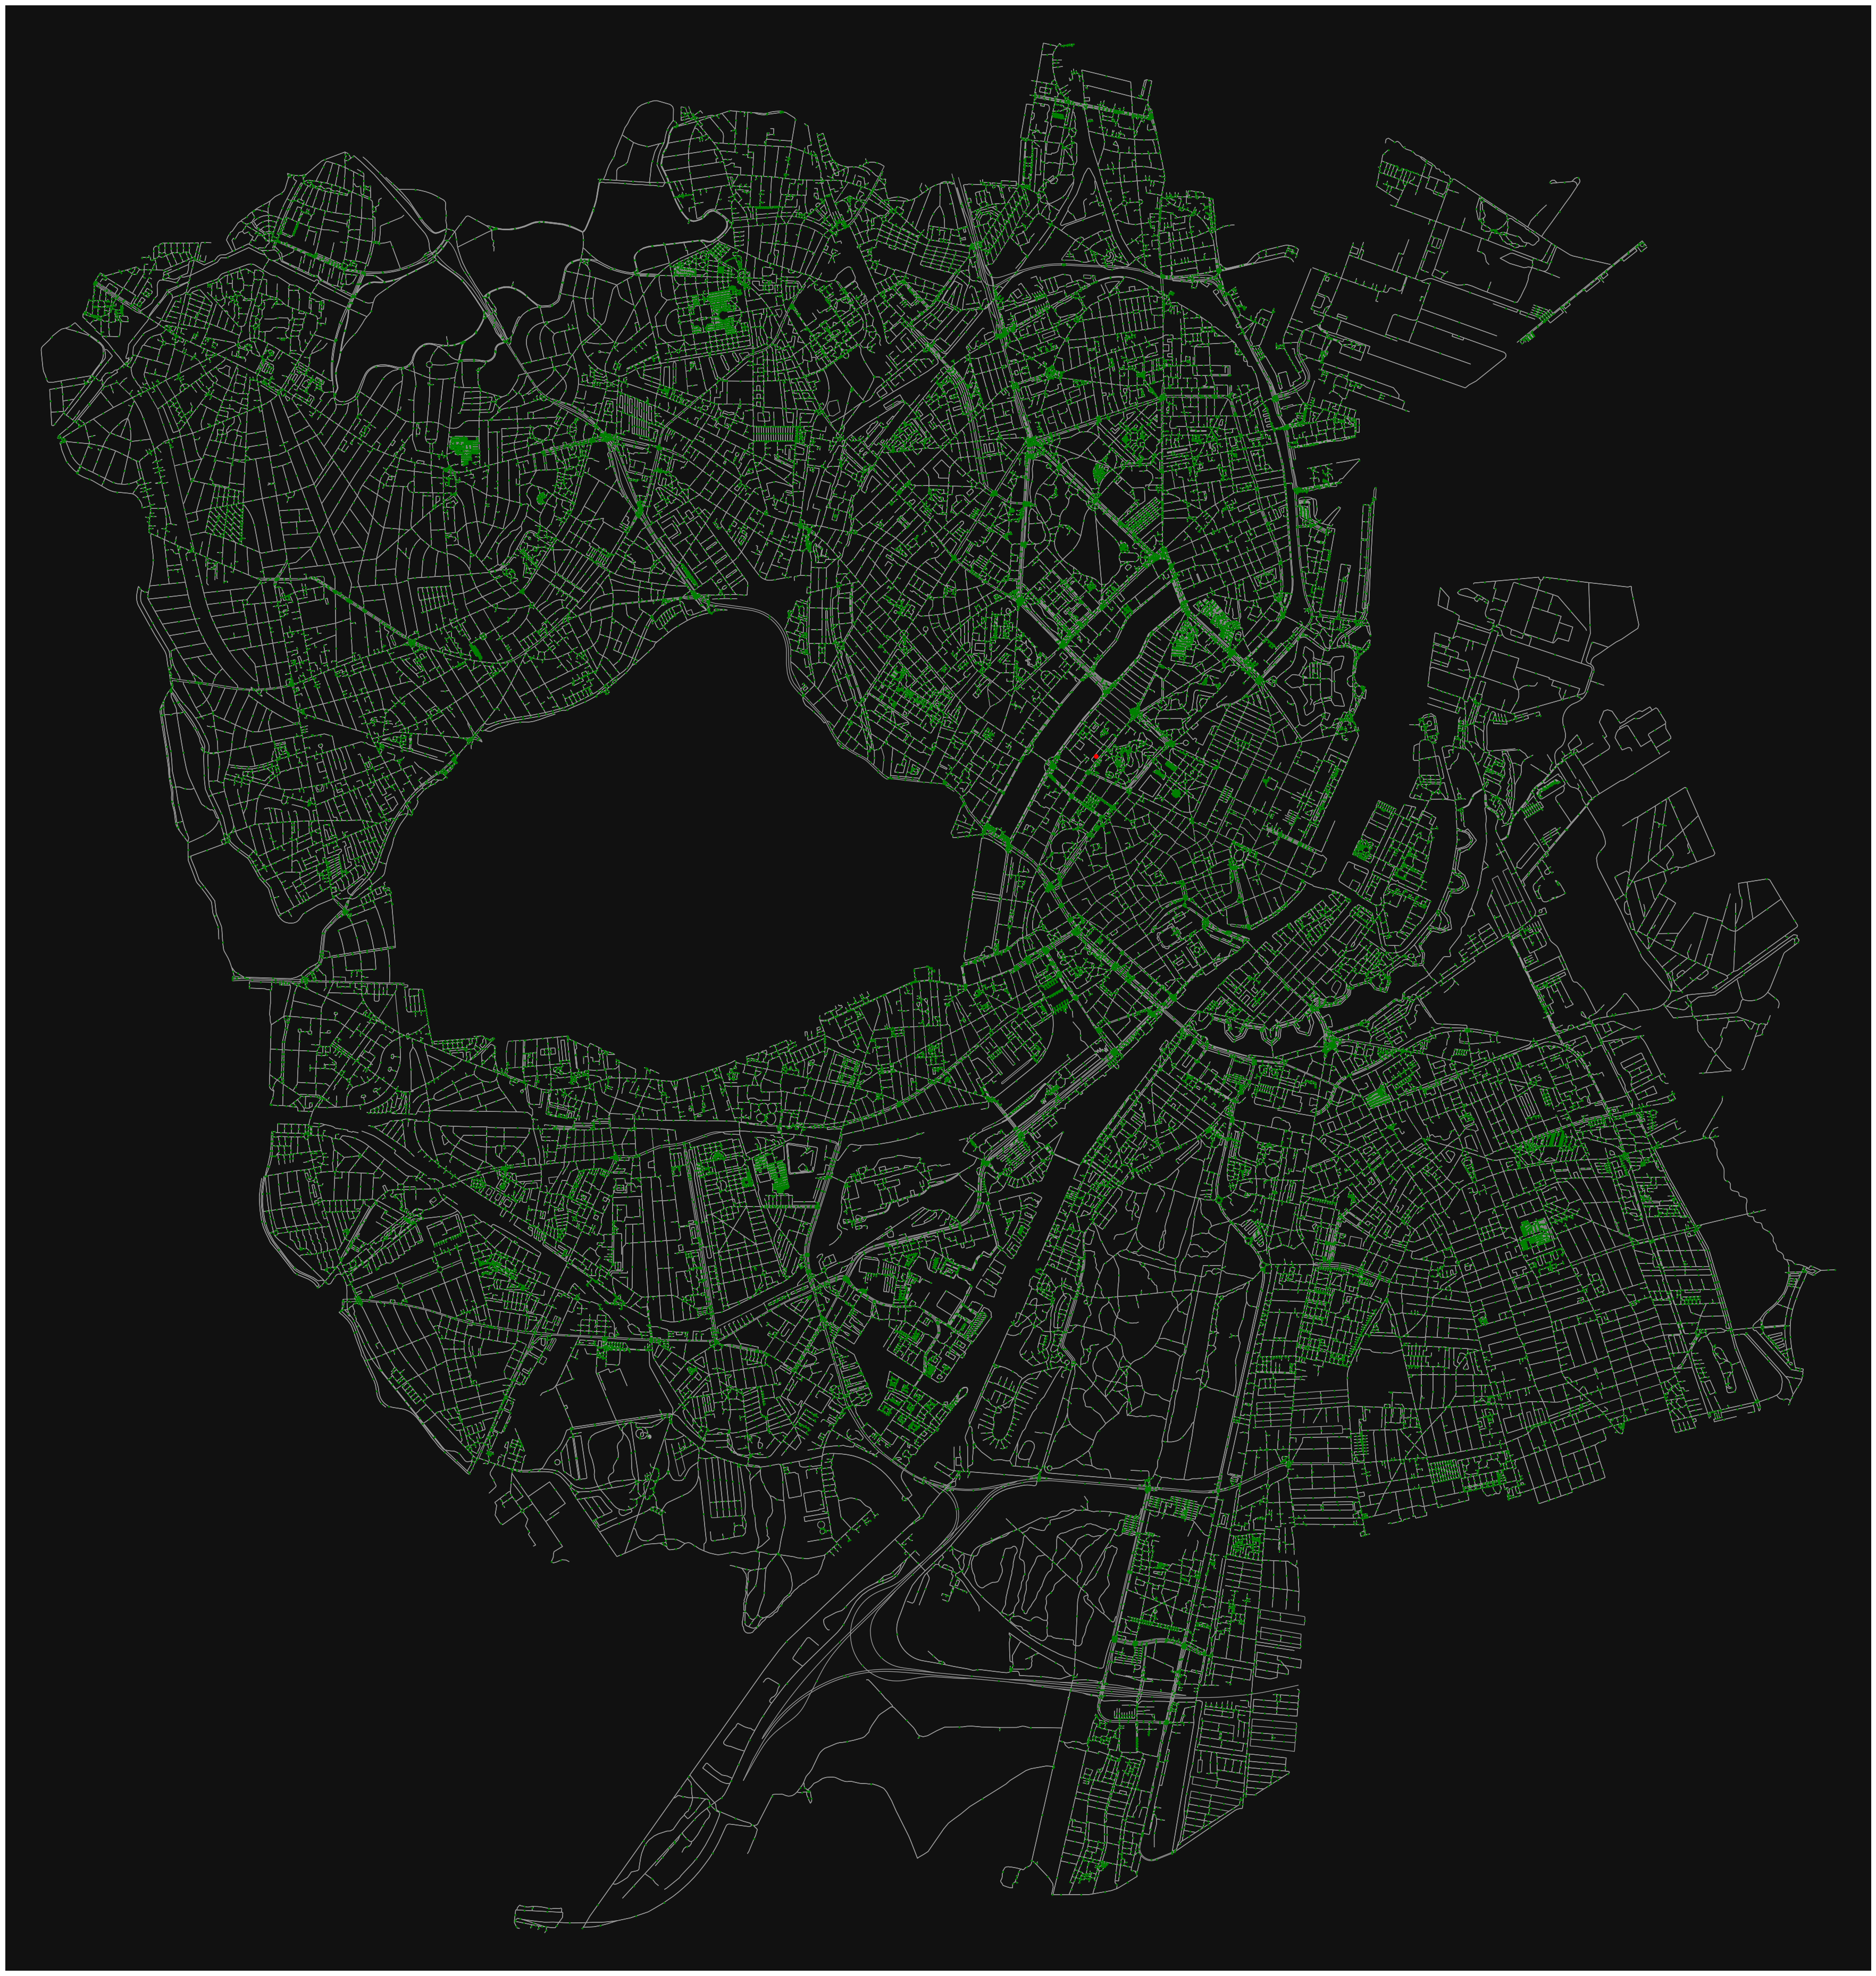

In [95]:
#Plot center point of each street
import matplotlib.pyplot as plt
fig, ax = ox.plot_graph(G, node_size=0, figsize=(48, 48), show=False, close=False)    
for i in range(0,len(gdf_edges)):
    ax.scatter(gdf_edges['center_point'].iloc[i].x, gdf_edges['center_point'].iloc[i].y, c='g', s = 2)    
    ax.scatter(copenhagen_center[1], copenhagen_center[0], c='r', s = 50)    
plt.show() 

In [112]:
#Find distances between roads and center
distance_to_center = []
for i in range(gdf_edges.shape[0]):
    distances=distance_to_center.append(geopy.distance.geodesic(copenhagen_center, (gdf_edges["center_point"][i].y,gdf_edges["center_point"][i].x)).km)
gdf_edges["distance_from_center"] = distance_to_center

In [113]:
#Print min and max distance
print("Longest distance from the center point: ", gdf_edges["distance_from_center"].max())
print("Shortest distance from the center point: ", gdf_edges["distance_from_center"].min())

Longest distance from the center point:  9.09422676342499
Shortest distance from the center point:  0.009502653478788614


In [114]:
gdf_edges["distance_from_center"].isna().any()

False

In [115]:
#Define numerical and categorical features 
numerical_columns = ["maxspeed", "length", "lanes", 'buildings_count', 'landuse_count','natural_count', 
                     'railways_p_count', 'roads_p_count', 'pofw_count', 'pois_count', 'pois_p_count',
                     'traffic_count', 'traffic_p_count', 'transport_p_count','water_count', 'waterways_p_count',
                    "distance_from_center"]

categorical_columns = ["highway", "bridge", "tunnel"]


#For testing street features
numerical_street_columns = ["maxspeed", "length", "lanes"]


In [1]:
#Create one hot function for categorical features
def onehot(dataframe):
    onehot = pd.get_dummies(dataframe,dtype=float)
    #onehot = onehot.to_numpy()
    return onehot

In [146]:
#Join dataframes to create collected testset

gdf_to_merge = gdf[['id', 'slaegt', 'bydelsnavn', 'placering', 'omgivelse', 'wkb_geometry', 'planteaar', 'lon', 
                    'lat', 'u','v', 'tree','tree_count', 'buildings_count', 'landuse_count','natural_count', 
                    'railways_p_count', 'roads_p_count', 'pofw_count', 'pois_count', 'pois_p_count', 
                    'traffic_count', 'traffic_p_count', 'transport_p_count','water_count', 'waterways_p_count']]

###Training
gdf_merged2 = gdf_edges.merge(gdf_to_merge,  on = ['u', 'v', 'buildings_count','landuse_count','natural_count', 
                                                   'railways_p_count', 'roads_p_count', 'pofw_count', 'pois_count',
                                                   'pois_p_count', 'traffic_count', 'traffic_p_count', 
                                                   'transport_p_count', 'water_count', 'waterways_p_count'],
                              how = 'outer')

#Fill tree features with 0s (because they don't contain streets)
gdf_merged2["slaegt"] = gdf_merged2["slaegt"].fillna(0)
gdf_merged2["bydelsnavn"] = gdf_merged2["bydelsnavn"].fillna(0)
gdf_merged2["placering"] = gdf_merged2["placering"].fillna(0)
gdf_merged2["omgivelse"] = gdf_merged2["omgivelse"].fillna(0)
gdf_merged2["planteaar"] = gdf_merged2["planteaar"].fillna(0)

#Fill nan values of streets again
gdf_merged2["maxspeed"] = gdf_merged2["maxspeed"].fillna(50)
gdf_merged2["length"] = gdf_merged2["length"].fillna(gdf_merged2["length"].mean())
gdf_merged2["lanes"] = gdf_merged2["lanes"].fillna(2)
gdf_merged2["highway"] = gdf_merged2["highway"].fillna('other')
gdf_merged2["bridge"] = gdf_merged2["bridge"].fillna(0)
gdf_merged2["tunnel"] = gdf_merged2["tunnel"].fillna(0)

#Create 0s in "tree" and "tree_count"
gdf_merged2["tree"] = gdf_merged2["tree"].fillna(0)
gdf_merged2["tree_count"] = gdf_merged2["tree_count"].fillna(0)

#Shuffle data
gdf_merged2 = shuffle(gdf_merged2, random_state = 0)

#Define labels
gdf_merged2_labels = gdf_merged2[['tree']]
gdf_merged2 = gdf_merged2.drop(['tree'], axis = 1)

#Train test split
X_train, X_test, y_train, y_test = train_test_split(gdf_merged2, gdf_merged2_labels, test_size = 0.1, random_state = 42)

#Create csv files with tree info
#X_test.to_csv("tree_info_x.csv")
#y_test.to_csv("tree_info_y.csv")

#Drop irrelevant columns
drop_columns = ["u","v", "osmid", "name", "geometry", "id", "wkb_geometry", "lat", "lon"]
X_train = X_train.drop(drop_columns, axis = 1)

numerical_train_columns = X_train.loc[:, numerical_columns]

categorical_train_columns = X_train.loc[:, categorical_columns]

#Define scaler for normalising numerical features
scaler = preprocessing.MinMaxScaler()

numerical_train_columns = scaler.fit_transform(numerical_train_columns)
numerical_train_columns = pd.DataFrame(numerical_train_columns, columns = numerical_columns)

#Onehot categorical features
categorical_train_columns = onehot(categorical_train_columns)

#Concatenate features column-wise
X_train_transformed = np.concatenate((numerical_train_columns,categorical_train_columns),axis=1)

X_train_array = pd.DataFrame(X_train_transformed)
y_train_array = pd.DataFrame(y_train)

#Repeat for test set
X_test = X_test.drop(drop_columns, axis = 1)

numerical_test_columns = X_test.loc[:, numerical_columns]

categorical_test_columns = X_test.loc[:, categorical_columns]

scaler = preprocessing.MinMaxScaler()
numerical_test_columns = scaler.fit_transform(numerical_test_columns)
numerical_test_columns = pd.DataFrame(numerical_test_columns, columns = numerical_columns)

categorical_test_columns = onehot(categorical_test_columns)
print(categorical_test_columns.columns)

X_test_transformed = np.concatenate((numerical_test_columns,categorical_test_columns),axis=1)

#Save data
'''with open('data/y_test.pickle', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('data/X_test.pickle', 'wb') as file:
    pickle.dump(X_test_transformed, file)
    
with open('data/X_train.pickle', 'wb') as file:
    pickle.dump(X_train_array, file)
    
with open('data/y_train.pickle', 'wb') as file:
    pickle.dump(y_train_array, file)'''

Index(['bridge', 'tunnel', 'highway_cycleway', 'highway_footway',
       'highway_other', 'highway_path', 'highway_residential',
       'highway_service', 'highway_tertiary'],
      dtype='object')


"with open('data/y_test.pickle', 'wb') as file:\n    pickle.dump(y_test, file)\n    \nwith open('data/X_test.pickle', 'wb') as file:\n    pickle.dump(X_test_transformed, file)\n    \nwith open('data/X_train.pickle', 'wb') as file:\n    pickle.dump(X_train_array, file)\n    \nwith open('data/y_train.pickle', 'wb') as file:\n    pickle.dump(y_train_array, file)"

### Prepare dataset for all tree types

In [145]:
#Repeat everything for all tree types

gdf_to_merge_all = gdf_all[['id', 'slaegt', 'bydelsnavn', 'placering', 'omgivelse', 'wkb_geometry', 
                                       'planteaar', 'lon', 'lat', 'u','v', 'tree','tree_count', 'buildings_count',
                                       'landuse_count','natural_count', 'railways_p_count',
                                        'roads_p_count', 'pofw_count', 'pois_count', 'pois_p_count',
                                    'traffic_count', 'traffic_p_count', 'transport_p_count','water_count', 'waterways_p_count']]

###Training'
gdf_merged2_all = gdf_edges.merge(gdf_to_merge_all,  on = ['u', 'v', 'buildings_count','landuse_count','natural_count', 'railways_p_count',
                                                   'roads_p_count', 'pofw_count', 'pois_count', 'pois_p_count',
                                                   'traffic_count', 'traffic_p_count', 'transport_p_count',
                                                   'water_count', 'waterways_p_count'],how = 'outer')

#Fill tree features with 0s (because they don't contain streets)
gdf_merged2_all["slaegt"] = gdf_merged2_all["slaegt"].fillna(0)
gdf_merged2_all["bydelsnavn"] = gdf_merged2_all["bydelsnavn"].fillna(0)
gdf_merged2_all["placering"] = gdf_merged2_all["placering"].fillna(0)
gdf_merged2_all["omgivelse"] = gdf_merged2_all["omgivelse"].fillna(0)
gdf_merged2_all["planteaar"] = gdf_merged2_all["planteaar"].fillna(0)

#Fill tree features with 0s (because they don't contain streets)
gdf_merged2_all["maxspeed"] = gdf_merged2_all["maxspeed"].fillna(50)
gdf_merged2_all["length"] = gdf_merged2_all["length"].fillna(gdf_merged2_all["length"].mean())
gdf_merged2_all["lanes"] = gdf_merged2_all["lanes"].fillna(2)
gdf_merged2_all["highway"] = gdf_merged2_all["highway"].fillna('other')
gdf_merged2_all["bridge"] = gdf_merged2_all["bridge"].fillna(0)
gdf_merged2_all["tunnel"] = gdf_merged2_all["tunnel"].fillna(0)


#Create 0s in "tree" and "tree_count"
gdf_merged2_all["tree"] = gdf_merged2_all["tree"].fillna(0)
gdf_merged2_all["tree_count"] = gdf_merged2_all["tree_count"].fillna(0)

#Shuffle data
gdf_merged2_all = shuffle(gdf_merged2_all, random_state = 0)

gdf_merged2_labels_all = gdf_merged2_all[['tree']]
gdf_merged2_all = gdf_merged2_all.drop(['tree'], axis = 1)

#Train test split
X_train, X_test, y_train, y_test = train_test_split(gdf_merged2_all, gdf_merged2_labels_all, test_size = 0.1, random_state = 42)

#X_test.to_csv("tree_info_x.csv")
#y_test.to_csv("tree_info_y.csv")

drop_columns = ["u","v", "osmid", "name", "geometry", "id", "wkb_geometry", "lat", "lon"]

X_train = X_train.drop(drop_columns, axis = 1)

numerical_train_columns = X_train.loc[:, numerical_columns]

categorical_train_columns = X_train.loc[:, categorical_columns]

scaler = preprocessing.MinMaxScaler()

numerical_train_columns = scaler.fit_transform(numerical_train_columns)
numerical_train_columns = pd.DataFrame(numerical_train_columns, columns = numerical_columns)

categorical_train_columns = onehot(categorical_train_columns)

X_train_transformed = np.concatenate((numerical_train_columns,categorical_train_columns),axis=1)

X_train_array = pd.DataFrame(X_train_transformed)
y_train_array = pd.DataFrame(y_train)

X_test = X_test.drop(drop_columns, axis = 1)

numerical_test_columns = X_test.loc[:, numerical_columns]

categorical_test_columns = X_test.loc[:, categorical_columns]

scaler = preprocessing.MinMaxScaler()
numerical_test_columns = scaler.fit_transform(numerical_test_columns)
numerical_test_columns = pd.DataFrame(numerical_test_columns, columns = numerical_columns)

categorical_test_columns = onehot(categorical_test_columns)
print(numerical_test_columns.columns, categorical_test_columns.columns)

X_test_transformed = np.concatenate((numerical_test_columns,categorical_test_columns),axis=1)

'''with open('data/y_test_all.pickle', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('data/X_test_all.pickle', 'wb') as file:
    pickle.dump(X_test_transformed, file)
    
with open('data/X_train_all.pickle', 'wb') as file:
    pickle.dump(X_train_array, file)
    
with open('data/y_train_all.pickle', 'wb') as file:
    pickle.dump(y_train_array, file)'''

Index(['maxspeed', 'length', 'lanes', 'buildings_count', 'landuse_count',
       'natural_count', 'railways_p_count', 'roads_p_count', 'pofw_count',
       'pois_count', 'pois_p_count', 'traffic_count', 'traffic_p_count',
       'transport_p_count', 'water_count', 'waterways_p_count',
       'distance_from_center'],
      dtype='object') Index(['bridge', 'tunnel', 'highway_cycleway', 'highway_footway',
       'highway_other', 'highway_path', 'highway_residential',
       'highway_service', 'highway_tertiary'],
      dtype='object')


"with open('data/y_test_all.pickle', 'wb') as file:\n    pickle.dump(y_test, file)\n    \nwith open('data/X_test_all.pickle', 'wb') as file:\n    pickle.dump(X_test_transformed, file)\n    \nwith open('data/X_train_all.pickle', 'wb') as file:\n    pickle.dump(X_train_array, file)\n    \nwith open('data/y_train_all.pickle', 'wb') as file:\n    pickle.dump(y_train_array, file)"

### Prepare dataset with only street features

In [138]:
#Repeat everything for only street features

gdf_to_merge_streets = gdf[['id', 'slaegt', 'bydelsnavn', 'placering', 'omgivelse', 'wkb_geometry', 
                                       'planteaar', 'lon', 'lat', 'u','v', 'tree','tree_count', 'buildings_count',
                                       'landuse_count','natural_count', 'railways_p_count',
                                        'roads_p_count', 'pofw_count', 'pois_count', 'pois_p_count',
                                    'traffic_count', 'traffic_p_count', 'transport_p_count','water_count', 'waterways_p_count']]

###Training'
gdf_merged2_streets = gdf_edges.merge(gdf_to_merge_streets,  on = ['u', 'v', 'buildings_count','landuse_count','natural_count', 'railways_p_count',
                                                   'roads_p_count', 'pofw_count', 'pois_count', 'pois_p_count',
                                                   'traffic_count', 'traffic_p_count', 'transport_p_count',
                                                   'water_count', 'waterways_p_count'],how = 'outer')

#Fill tree features with 0s (because they don't contain streets)
gdf_merged2_streets["slaegt"] = gdf_merged2_streets["slaegt"].fillna(0)
gdf_merged2_streets["bydelsnavn"] = gdf_merged2_streets["bydelsnavn"].fillna(0)
gdf_merged2_streets["placering"] = gdf_merged2_streets["placering"].fillna(0)
gdf_merged2_streets["omgivelse"] = gdf_merged2_streets["omgivelse"].fillna(0)
gdf_merged2_streets["planteaar"] = gdf_merged2_streets["planteaar"].fillna(0)

#Fill tree features with 0s (because they don't contain streets)
gdf_merged2_streets["maxspeed"] = gdf_merged2_streets["maxspeed"].fillna(50)
gdf_merged2_streets["length"] = gdf_merged2_streets["length"].fillna(gdf_merged2_streets["length"].mean())
gdf_merged2_streets["lanes"] = gdf_merged2_streets["lanes"].fillna(2)
gdf_merged2_streets["highway"] = gdf_merged2_streets["highway"].fillna('other')
gdf_merged2_streets["bridge"] = gdf_merged2_streets["bridge"].fillna(0)
gdf_merged2_streets["tunnel"] = gdf_merged2_streets["tunnel"].fillna(0)


#Create 0s in "tree" and "tree_count"
gdf_merged2_streets["tree"] = gdf_merged2_streets["tree"].fillna(0)
gdf_merged2_streets["tree_count"] = gdf_merged2_streets["tree_count"].fillna(0)

#Shuffle data
gdf_merged2_streets = shuffle(gdf_merged2_streets, random_state = 0)

gdf_merged2_labels_streets = gdf_merged2_streets[['tree']]
gdf_merged2_streets = gdf_merged2_streets.drop(['tree'], axis = 1)

#Train test split
X_train, X_test, y_train, y_test = train_test_split(gdf_merged2_streets, gdf_merged2_labels_streets, test_size = 0.1, random_state = 42)

#x_train_array = np.zeros(shape=(0, 27))
#y_train_array = np.zeros(shape=(0, 1))

drop_columns = ["u","v", "osmid", "name", "geometry", "id", "wkb_geometry", "lat", "lon"]
drop_spatial_columns = ['buildings_count',
                                   'landuse_count','natural_count', 'railways_p_count',
                                    'roads_p_count', 'pofw_count', 'pois_count', 'pois_p_count',
                                'traffic_count', 'traffic_p_count', 'transport_p_count','water_count', 'waterways_p_count',
                    "distance_from_center"]

X_train = X_train.drop(drop_columns, axis = 1)

numerical_train_columns = X_train.loc[:, numerical_columns]

categorical_train_columns = X_train.loc[:, categorical_columns]

scaler = preprocessing.MinMaxScaler()

numerical_train_columns = scaler.fit_transform(numerical_train_columns)
numerical_train_columns = pd.DataFrame(numerical_train_columns, columns = numerical_columns)
numerical_train_columns = numerical_train_columns.drop(drop_spatial_columns, axis = 1)

categorical_train_columns = onehot(categorical_train_columns)

X_train_transformed = np.concatenate((numerical_train_columns,categorical_train_columns),axis=1)

X_train_array = pd.DataFrame(X_train_transformed)
y_train_array = pd.DataFrame(y_train)

X_test = X_test.drop(drop_columns, axis = 1)

numerical_test_columns = X_test.loc[:, numerical_columns]

categorical_test_columns = X_test.loc[:, categorical_columns]

numerical_test_columns = scaler.fit_transform(numerical_test_columns)
numerical_test_columns = pd.DataFrame(numerical_test_columns, columns = numerical_columns)
numerical_test_columns = numerical_test_columns.drop(drop_spatial_columns, axis = 1)


categorical_test_columns = onehot(categorical_test_columns)
print(numerical_test_columns.columns)
print(categorical_test_columns.columns)

X_test_transformed = np.concatenate((numerical_test_columns,categorical_test_columns),axis=1)

'''with open('data/y_test_streets.pickle', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('data/X_test_streets.pickle', 'wb') as file:
    pickle.dump(X_test_transformed, file)
    
with open('data/X_train_streets.pickle', 'wb') as file:
    pickle.dump(X_train_array, file)
    
with open('data/y_train_streets.pickle', 'wb') as file:
    pickle.dump(y_train_array, file)'''
    

Index(['maxspeed', 'length', 'lanes'], dtype='object')
Index(['bridge', 'tunnel', 'highway_cycleway', 'highway_footway',
       'highway_other', 'highway_path', 'highway_residential',
       'highway_service', 'highway_tertiary'],
      dtype='object')


In [41]:
#Merge temporal tree training and validation data with random instance of data without trees

gdf_to_merge = gdf[['id', 'slaegt', 'bydelsnavn', 'placering', 'omgivelse', 'wkb_geometry', 
                                       'planteaar', 'lon', 'lat', 'u','v', 'tree','tree_count', 'buildings_count',
                                       'landuse_count','natural_count', 'railways_p_count',
                                        'roads_p_count', 'pofw_count', 'pois_count', 'pois_p_count',
                                    'traffic_count', 'traffic_p_count', 'transport_p_count','water_count', 'waterways_p_count']]

###Training'
gdf_merged2 = gdf_edges.merge(gdf_to_merge,  on = ['u', 'v', 'buildings_count','landuse_count','natural_count', 'railways_p_count',
                                                   'roads_p_count', 'pofw_count', 'pois_count', 'pois_p_count',
                                                   'traffic_count', 'traffic_p_count', 'transport_p_count',
                                                   'water_count', 'waterways_p_count'],how = 'outer')

#Fill tree features with 0s (because they don't contain streets)
gdf_merged2["slaegt"] = gdf_merged2["slaegt"].fillna(0)
gdf_merged2["bydelsnavn"] = gdf_merged2["bydelsnavn"].fillna(0)
gdf_merged2["placering"] = gdf_merged2["placering"].fillna(0)
gdf_merged2["omgivelse"] = gdf_merged2["omgivelse"].fillna(0)
gdf_merged2["planteaar"] = gdf_merged2["planteaar"].fillna(0)

#Fill tree features with 0s (because they don't contain streets)
gdf_merged2["maxspeed"] = gdf_merged2["maxspeed"].fillna(50)
gdf_merged2["length"] = gdf_merged2["length"].fillna(gdf_merged2["length"].mean())
gdf_merged2["lanes"] = gdf_merged2["lanes"].fillna(2)
gdf_merged2["highway"] = gdf_merged2["highway"].fillna('other')
gdf_merged2["bridge"] = gdf_merged2["bridge"].fillna(0)
gdf_merged2["tunnel"] = gdf_merged2["tunnel"].fillna(0)


#Create 0s in "tree" and "tree_count"
gdf_merged2["tree"] = gdf_merged2["tree"].fillna(0)
gdf_merged2["tree_count"] = gdf_merged2["tree_count"].fillna(0)

#Shuffle data
gdf_merged2 = shuffle(gdf_merged2, random_state = 0)

#Split in 10 folds  
s1, s2, s3, s4, s5, s6, s7, s8, s9, s10 = np.array_split(gdf_merged2, 10)
print(s10["planteaar"])

y_test = s10[['tree']]
x_test = s10.drop('tree', axis = 1)

train_val_splits = [s1, s2, s3, s4, s5, s6, s7, s8, s9]
#print(s5)
folds = []

#x_train_array = np.zeros(shape=(0, 27))
#y_train_array = np.zeros(shape=(0, 1))

drop_columns = ["u","v", "osmid", "name", "geometry", "id", "wkb_geometry", "lat", "lon"]

# Fix splits
for i in range(len(train_val_splits)):
    val = train_val_splits[i]
    val = shuffle(val)
    #print(val)
    y_val = val[['tree']]
    X_val = val.drop('tree', axis = 1)
    #print(train_val_splits[:i] )
    train_splits = train_val_splits[:i] + train_val_splits[i+1:]
    train = pd.concat(train_splits)
    train = shuffle(train)
    #print("train: ", train.index[0])
    #print("val: ", val.index[0])
    y_train = train[['tree']]
    X_train = train.drop('tree', axis = 1)
    
    X_train = X_train.drop(drop_columns, axis = 1)
    X_val = X_val.drop(drop_columns, axis = 1)
    
        #numerical_train_columns = df_train.loc[:,["maxspeed", "length", "lanes", "buildings_count", "landuse_count", "natural_count", 
        #                             "pofw_count", "pois_count", "traffic_count", "water_count", "planteaar", "tree_count"]]
    numerical_train_columns = X_train.loc[:, numerical_columns]

    #numerical_val_columns = df_val.loc[:,["maxspeed", "length", "lanes", "buildings_count", "landuse_count", "natural_count", 
    #                             "pofw_count", "pois_count", "traffic_count", "water_count", "planteaar", "tree_count"]]
    numerical_val_columns = X_val.loc[:, numerical_columns]

    #categorical_val_columns = df_val.loc[:,["highway", "bridge", "tunnel", "slaegt", "bydelsnavn", "placering", "omgivelse"]]
    #categorical_train_columns = df_train.loc[:,["highway", "bridge", "tunnel", "omgivelse"]]
    categorical_train_columns = X_train.loc[:, categorical_columns]

    #categorical_val_columns = df_val.loc[:,["highway", "bridge", "tunnel", "slaegt", "bydelsnavn", "placering", "omgivelse"]]
    #categorical_val_columns = df_val.loc[:,["highway", "bridge", "tunnel", "omgivelse"]]
    categorical_val_columns = X_val.loc[:, categorical_columns]
    
    #print(X_train.columns.tolist())

    #Normalise numerical columns
    #numerical_train_columns = normalize_data(numerical_train_columns)
    #numerical_val_columns = normalize_data(numerical_val_columns)
    #print("LENGTH BEFORE", numerical_train_columns.shape)
    #print("LENGTH BEFORE", numerical_train_columns)
    numerical_train_columns = preprocessing.normalize(numerical_train_columns)
    #TITLES
    numerical_train_columns = pd.DataFrame(numerical_train_columns, columns = numerical_columns)

    
    #print("LNGTH AFTER", numerical_train_columns.shape)
    numerical_val_columns = preprocessing.normalize(numerical_val_columns)
    #TITLES
    numerical_val_columns = pd.DataFrame(numerical_val_columns, columns = numerical_columns)

    #Onehot encode categorical columns
    categorical_train_columns = onehot(categorical_train_columns)
    #TITLES
    #categorical_train_columns = pd.DataFrame(categorical_train_columns, columns = categorical_columns)
    #categorical_train_columns.columns = ohenc.get_feature_names()
    
    categorical_val_columns = onehot(categorical_val_columns)
    #TITLES

    #Concatenate the normalised and onehot encoded arrays
    X_train_transformed = np.concatenate((numerical_train_columns,categorical_train_columns),axis=1)
    X_val_transformed = np.concatenate((numerical_val_columns,categorical_val_columns),axis=1)
    
    x_train_array = np.vstack([X_train_transformed, X_val_transformed])
    #x_train_array = np.vstack([X_train_array, X_val_transformed])

    y_train_array = np.vstack([y_train, y_val])
    #y_train_array = np.vstack([y_train_array, y_val])
    
    folds.append([i, X_train_transformed, y_train, X_val_transformed, y_val])
    
folds = pd.DataFrame(folds)
x_train_array = pd.DataFrame(x_train_array)
y_train_array = pd.DataFrame(y_train_array)

###TEST
#val = shuffle(val)
#print(val)
#y_val = val[['tree']]
#X_val = val.drop('tree', axis = 1)
#print(train_val_splits[:i] )
#train_splits = train_val_splits[:i] + train_val_splits[i+1:]
#train = pd.concat(train_splits)
#train = shuffle(train)
#print("train: ", train.index[0])
#print("val: ", val.index[0])
#y_train = train[['tree']]
#X_train = train.drop('tree', axis = 1)

#X_train = X_train.drop(drop_columns, axis = 1)
X_test = x_test.drop(drop_columns, axis = 1)

    #numerical_train_columns = df_train.loc[:,["maxspeed", "length", "lanes", "buildings_count", "landuse_count", "natural_count", 
    #                             "pofw_count", "pois_count", "traffic_count", "water_count", "planteaar", "tree_count"]]
#numerical_train_columns = X_train.loc[:, numerical_columns]

#numerical_val_columns = df_val.loc[:,["maxspeed", "length", "lanes", "buildings_count", "landuse_count", "natural_count", 
#                             "pofw_count", "pois_count", "traffic_count", "water_count", "planteaar", "tree_count"]]
numerical_test_columns = X_test.loc[:, numerical_columns]

#categorical_val_columns = df_val.loc[:,["highway", "bridge", "tunnel", "slaegt", "bydelsnavn", "placering", "omgivelse"]]
#categorical_train_columns = df_train.loc[:,["highway", "bridge", "tunnel", "omgivelse"]]
#categorical_train_columns = X_train.loc[:, categorical_columns]

#categorical_val_columns = df_val.loc[:,["highway", "bridge", "tunnel", "slaegt", "bydelsnavn", "placering", "omgivelse"]]
#categorical_val_columns = df_val.loc[:,["highway", "bridge", "tunnel", "omgivelse"]]
categorical_test_columns = X_test.loc[:, categorical_columns]

#print(X_train.columns.tolist())

#Normalise numerical columns
#numerical_train_columns = normalize_data(numerical_train_columns)
#numerical_val_columns = normalize_data(numerical_val_columns)
#print("LENGTH BEFORE", numerical_train_columns.shape)
#print("LENGTH BEFORE", numerical_train_columns)
#numerical_train_columns = preprocessing.normalize(numerical_train_columns)
#TITLES
#numerical_train_columns = pd.DataFrame(numerical_train_columns, columns = numerical_columns)


#print("LNGTH AFTER", numerical_train_columns.shape)
numerical_test_columns = preprocessing.normalize(numerical_test_columns)
#TITLES
numerical_test_columns = pd.DataFrame(numerical_test_columns, columns = numerical_columns)

#Onehot encode categorical columns
#categorical_train_columns = onehot(categorical_train_columns)
#TITLES
#categorical_train_columns = pd.DataFrame(categorical_train_columns, columns = categorical_columns)
#categorical_train_columns.columns = ohenc.get_feature_names()

categorical_test_columns = onehot(categorical_test_columns)
print(categorical_test_columns.columns)
#TITLES

#Concatenate the normalised and onehot encoded arrays
#X_train_transformed = np.concatenate((numerical_train_columns,categorical_train_columns),axis=1)
X_test_transformed = np.concatenate((numerical_test_columns,categorical_test_columns),axis=1)

#x_train_array = np.vstack([X_train_transformed, X_val_transformed])
#x_train_array = np.vstack([X_train_array, X_val_transformed])

#y_train_array = np.vstack([y_train, y_val])
#y_train_array = np.vstack([y_train_array, y_val])

#folds.append([i, X_train_transformed, y_train, X_val_transformed, y_val])

#with open('folds.pickle', 'wb') as file:
#    pickle.dump(folds, file)

#with open('y_test.pickle', 'wb') as file:
#    pickle.dump(y_test, file)
    
#with open('X_test.pickle', 'wb') as file:
#    pickle.dump(X_test_transformed, file)
    
#with open('X_train.pickle', 'wb') as file:
#    pickle.dump(x_train_array, file)
    
#with open('y_train.pickle', 'wb') as file:
#    pickle.dump(y_train_array, file)

1230        0.0
67196       0.0
71863       0.0
32779       0.0
50591       0.0
          ...  
21243       0.0
45891       0.0
42613    2000.0
43567       0.0
68268       0.0
Name: planteaar, Length: 10411, dtype: float64
Index(['bridge', 'tunnel', 'highway_cycleway', 'highway_footway',
       'highway_other', 'highway_path', 'highway_residential',
       'highway_service', 'highway_tertiary'],
      dtype='object')
